In [2]:
import os
from thermof.read import read_log, read_thermo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
thermo_headers = 'Step Temp Press TotEng E_pair E_mol Fmax Fnorm c_C1[1] c_C1[2] c_C1[3]'
thermo_keys = ['step', 'temp', 'press', 'etotal', 'epair', 'emol', 'fmax', 'fnorm', 'x', 'y', 'z']

In [6]:
scandir = 'data/scan2'
scanlist = [os.path.join(scandir, i) for i in os.listdir(scandir)]

In [7]:
nx, ny = 19, 14
matrixdata = {'emol': np.zeros((nx, ny)), 'epair': np.zeros((nx, ny)), 'etotal': np.zeros((nx, ny)), 'fmax': np.zeros((nx, ny)), 'fnorm': np.zeros((nx, ny)),
              'dx': np.zeros((nx, ny)), 'dy': np.zeros((nx, ny)), 'z': np.zeros((nx, ny))}
data = {'x': [], 'y': [], 'z': [], 'emol': [], 'epair': [], 'etotal': [], 'fmax': [], 'fnorm': [], 'x0': [], 'y0': []}

In [8]:
for simdir in scanlist:
    logfile = os.path.join(simdir, 'log.HtBDC_Cu110')
    try:
        _, xi, yi = [int(i) for i in os.path.basename(simdir).split('-')]
        thermo_data = read_log(logfile, headers=thermo_headers)
        thermo = read_thermo(thermo_data, headers=thermo_keys)[0]
        for k in ['x', 'y', 'z', 'etotal']:
            data[k].append(thermo[k][-1])
        for k in ['emol', 'epair', 'etotal', 'fmax', 'fnorm', 'z']:
            matrixdata[k][xi][yi] = thermo[k][-1]
        matrixdata['dx'][xi][yi] = abs(thermo['x'][0] - thermo['x'][-1])
        matrixdata['dy'][xi][yi] = abs(thermo['y'][0] - thermo['y'][-1])
        data['x0'].append(thermo['x'][0])
        data['y0'].append(thermo['y'][0])
    except Exception as e:
        print(e, logfile)

In [9]:
def subplot(plot_data, nrow=1, width=3, height=3, dpi=200, save=None, title=None):
    n_plots = len(plot_data)
    ncol = np.ceil(n_plots / nrow)
    figsize = (ncol * width, nrow * height)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    fig.subplots_adjust(hspace=.5, wspace=.25)
    for idx, data in enumerate(plot_data, start=1):
        ax = fig.add_subplot(nrow, ncol, idx)
        img = ax.imshow(data, origin='lower')
        plt.colorbar(img)
        if title is not None:
            plt.title(title[idx - 1])
    if save is not None:
        plt.savefig(save, dpi=dpi, transparent=True, bbox_inches='tight')

In [10]:
keys = ['emol', 'epair', 'etotal', 'z', 'fmax', 'fnorm', 'dx', 'dy']
pltdata = [matrixdata[i].T for i in keys]

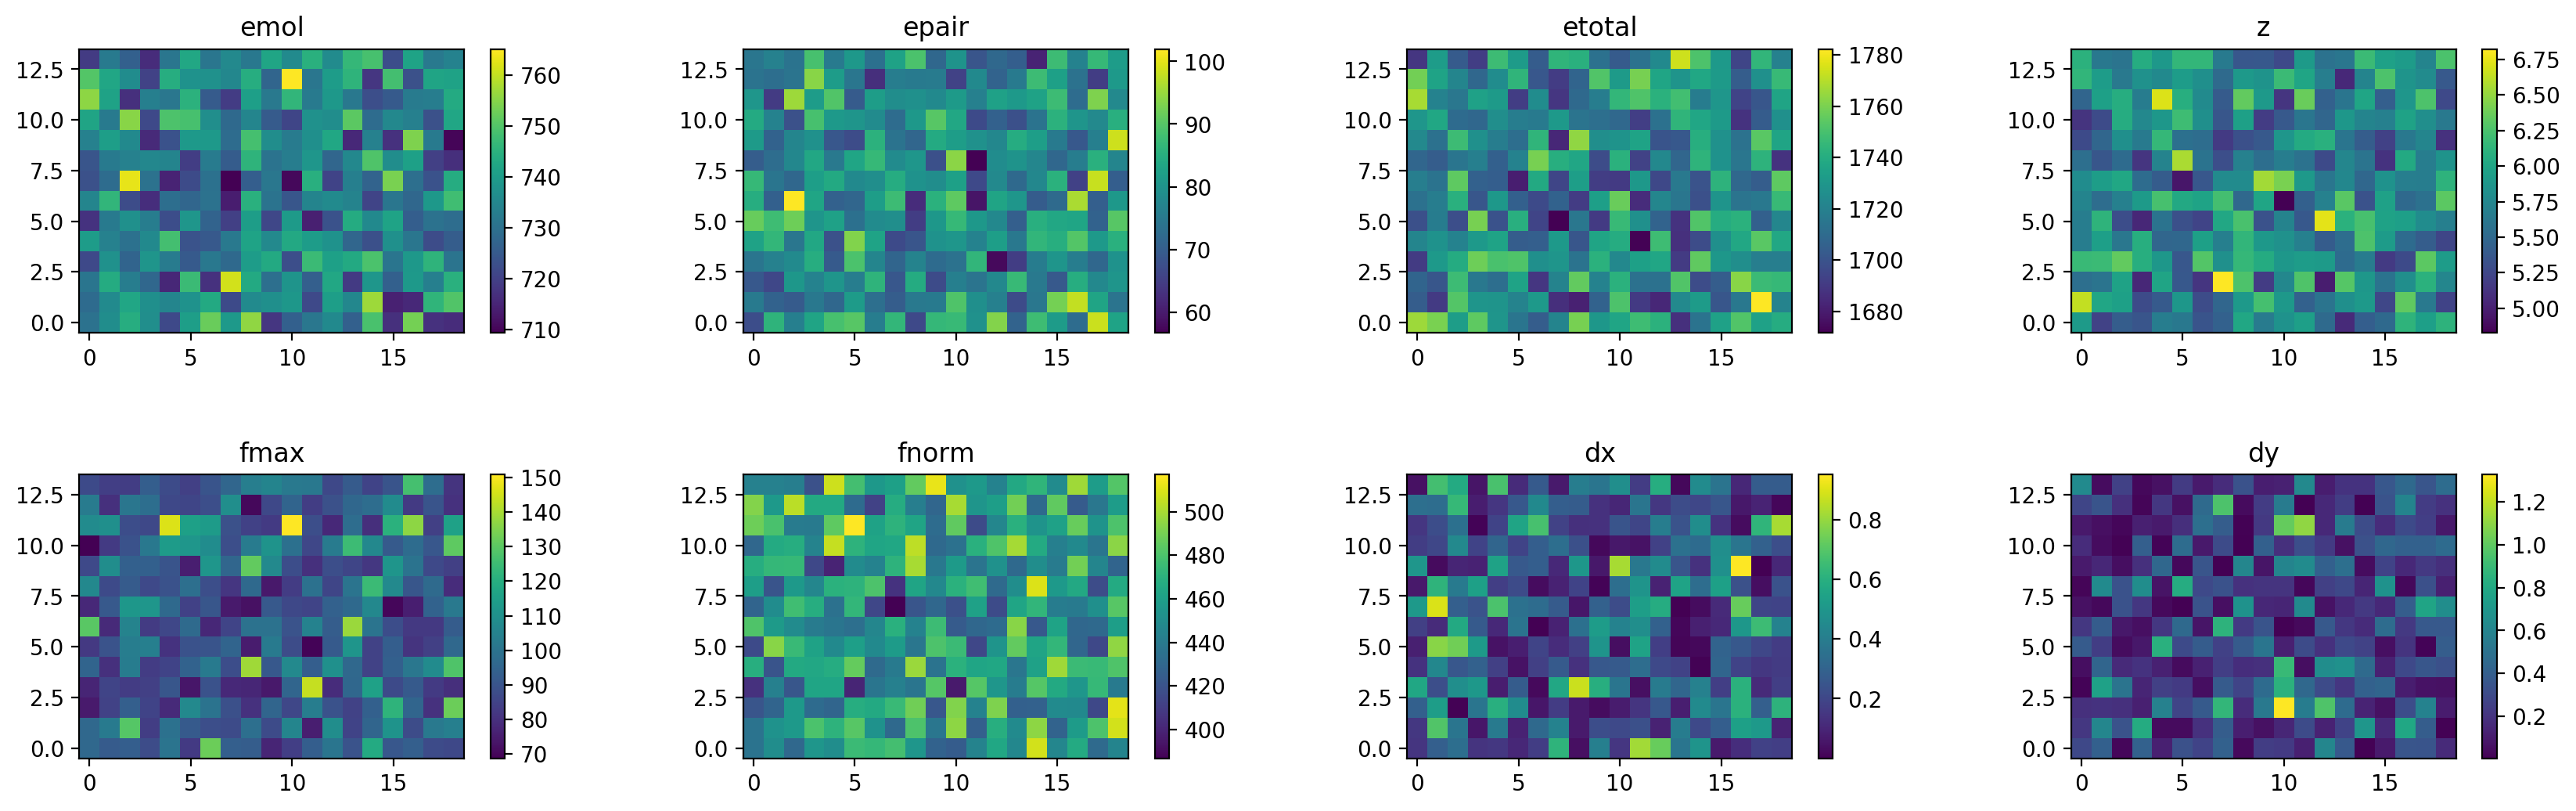

In [11]:
subplot(pltdata, nrow=2, height=3, width=5.2, title=keys)

In [12]:
surfatoms1 = [[21.582, 22.8912], [25.179, 22.8912], [21.582, 25.4346], [25.179, 25.4346]]
surfatoms2 = [23.3805, 24.1629]
def get_numbins(data, binsize):
    return abs(max(data) - min(data)) / binsize

### Distance histograms

In [57]:
from scipy.stats import norm
import matplotlib.mlab as mlab


def plot_hist(data, bins=50, color='b', linestyle='k', alpha=0.7, lw=1.5):
    (mu, sigma) = norm.fit(data)
    # the histogram of the data
    n, bins, patches = plt.hist(data, bins, normed=1, facecolor=color, alpha=alpha)
    # add a 'best fit' line
    y = mlab.normpdf(bins, mu, sigma)
    l = plt.plot(bins, y, linestyle, linewidth=lw)

In [65]:
histdata = {'allx': np.zeros(14), 'x': [], 'xi': [], 'y': [], 'yi': []}

In [61]:
for simdir in scanlist:
    logfile = os.path.join(simdir, 'log.HtBDC_Cu110')
    _, xi, yi = [int(i) for i in os.path.basename(simdir).split('-')]
    if yi == 1:
        thermo_data = read_log(logfile, headers=thermo_headers)
        thermo = read_thermo(thermo_data, headers=thermo_keys)[0]
        histdata['x'].append(thermo['x'])
        histdata['xi'].append(xi)

In [62]:
def subplot(plot_data, plot_fun, nrow=1, width=3, height=3, dpi=200, save=None, title=None):
    n_plots = len(plot_data)
    ncol = np.ceil(n_plots / nrow)
    figsize = (ncol * width, nrow * height)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    fig.subplots_adjust(hspace=.5, wspace=.25)
    for idx, data in enumerate(plot_data, start=1):
        ax = fig.add_subplot(nrow, ncol, idx)
        plot_fun(data)
        if title is not None:
            plt.title(title[idx - 1])
    if save is not None:
        plt.savefig(save, dpi=dpi, transparent=True, bbox_inches='tight')

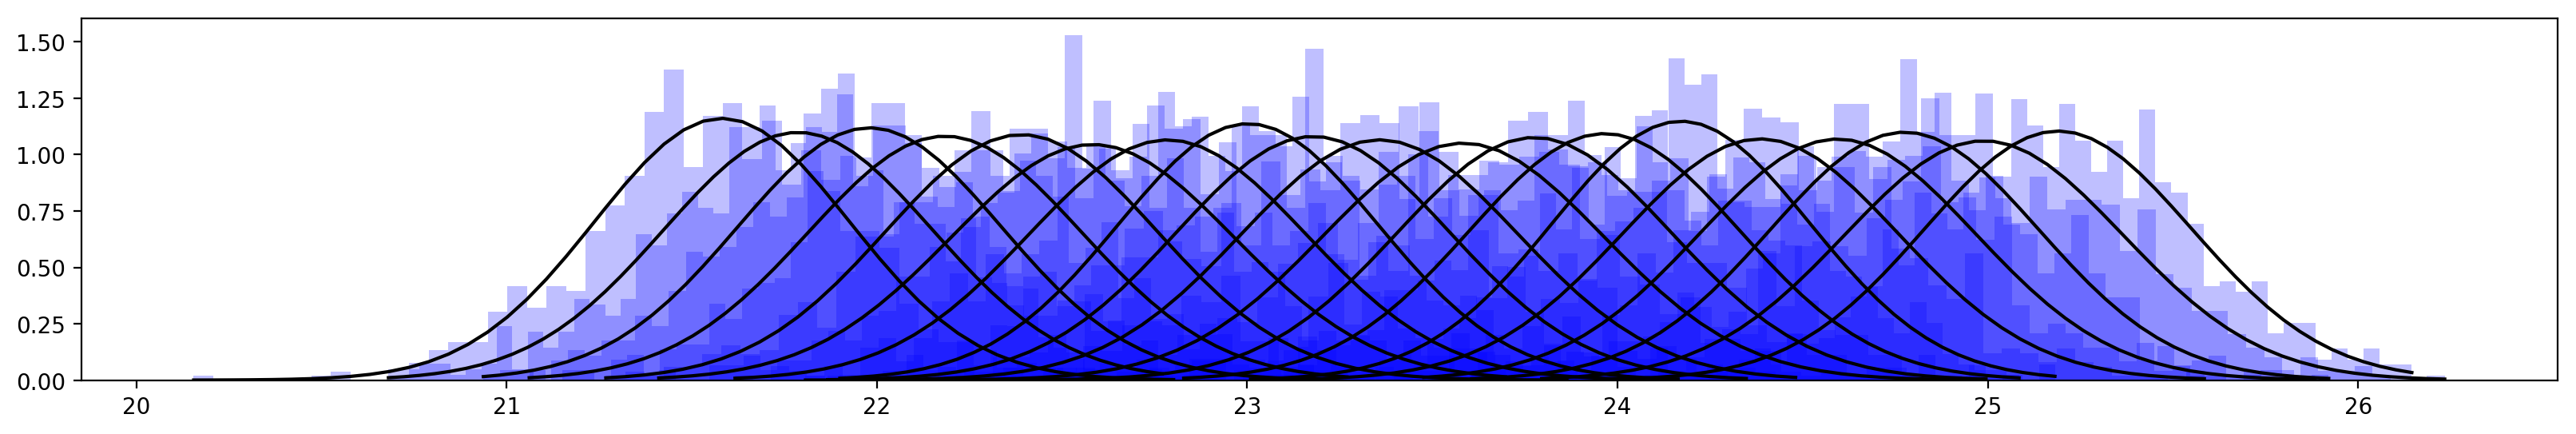

In [64]:
fig = plt.figure(figsize=(20, 3), dpi=200)
for i in range(19):
    idx = histdata['xi'].index(i)
    plot_hist(histdata['x'][idx], alpha=0.25)

### Final positions

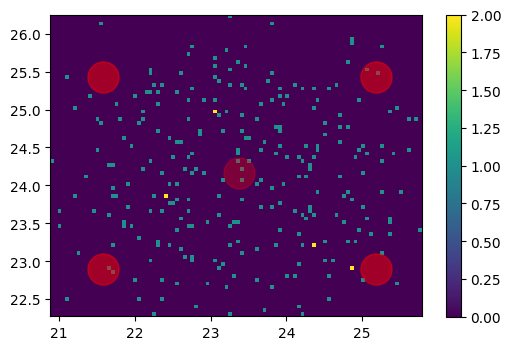

In [13]:
binsize = 0.05
nbins = (get_numbins(data['x'], binsize), get_numbins(data['y'], binsize))
H, xedges, yedges = np.histogram2d(data['x'], data['y'], bins=nbins)
H = H.T  # Let each row list bins with common y range.
plt.imshow(H, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar()
plt.scatter([i[0] for i in surfatoms1], [i[1] for i in surfatoms1], c='r', alpha=0.5, s=500)
plt.scatter(surfatoms2[0], surfatoms2[1], c='r', alpha=0.3, s=500)

### Starting positions

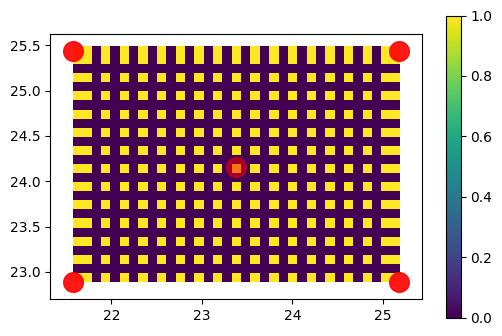

In [14]:
# xedges = np.arange(nx)
# yedges = np.arange(ny)
binsize = 0.1
nbins = (get_numbins(data['x0'], binsize), get_numbins(data['y0'], binsize))
H, xedges, yedges = np.histogram2d(data['x0'], data['y0'], bins=nbins)
H = H.T  # Let each row list bins with common y range.
plt.imshow(H, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar()
plt.scatter([i[0] for i in surfatoms1], [i[1] for i in surfatoms1], c='r', alpha=0.9, s=200)
plt.scatter(surfatoms2[0], surfatoms2[1], c='r', alpha=0.5, s=200)

In [15]:
len(matrixdata['etotal'])

19

In [16]:
len(data['etotal'])

266

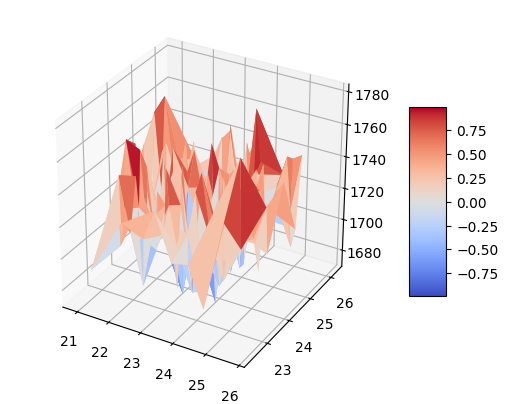

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# for i in range(19):
ax.plot_trisurf(data['x'], data['y'], data['etotal'], cmap=cm.coolwarm,)
fig.colorbar(surf, shrink=0.5, aspect=5)

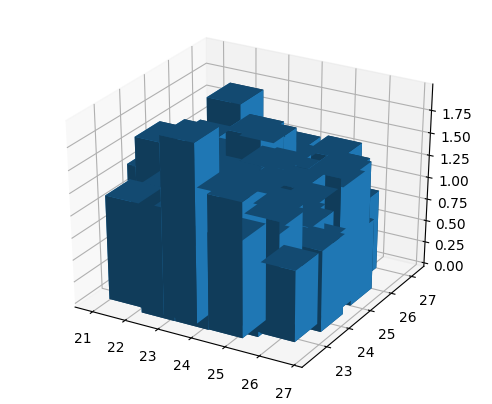

In [20]:
# setup the figure and axes
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(111, projection='3d')
top = np.array(data['z'])
top = top - min(top)
bottom = np.zeros_like(top)
width = depth = 1


ax1.bar3d(data['x'], data['y'], bottom, width, depth, top)
plt.show()